In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import time
import copy
from tqdm.notebook import tqdm

In [2]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = efficientnet_v2_s(EfficientNet_V2_S_Weights)

num_classes = len(classes)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
)

model = model.to('cuda')

/home/abr1/anaconda3/envs/term_project/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/abr1/anaconda3/envs/term_project/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              SiLU-3           [-1, 24, 16, 16]               0
            Conv2d-4           [-1, 24, 16, 16]           5,184
       BatchNorm2d-5           [-1, 24, 16, 16]              48
              SiLU-6           [-1, 24, 16, 16]               0
   StochasticDepth-7           [-1, 24, 16, 16]               0
       FusedMBConv-8           [-1, 24, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           5,184
      BatchNorm2d-10           [-1, 24, 16, 16]              48
             SiLU-11           [-1, 24, 16, 16]               0
  StochasticDepth-12           [-1, 24, 16, 16]               0
      FusedMBConv-13           [-1, 24, 16, 16]               0
           Conv2d-14             [-1, 9

In [7]:
## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = trainloader
dataloaders['test'] = testloader

batch_num['train'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['test'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


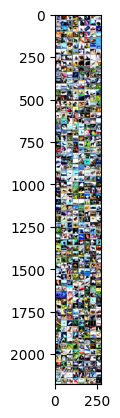

dog   horse deer  deer  ship  dog   horse car   cat   deer  bird  frog  cat   deer  car   dog   car   ship  dog   dog   frog  car   car   plane cat   truck bird  horse cat   deer  bird  truck horse dog   horse dog   cat   frog  car   plane horse plane horse truck horse truck plane plane ship  frog  deer  deer  dog   ship  dog   ship  cat   horse truck frog  dog   horse plane cat   dog   horse cat   deer  dog   cat   plane cat   plane dog   deer  car   cat   bird  horse frog  plane car   ship  plane deer  cat   frog  horse plane frog  ship  truck car   car   truck dog   plane ship  car   truck car   horse truck deer  bird  cat   deer  bird  bird  bird  truck truck dog   horse horse ship  car   frog  frog  frog  dog   dog   horse bird  horse cat   ship  frog  frog  cat   car   bird  car   deer  dog   cat   deer  cat   plane horse horse deer  bird  plane bird  bird  cat   dog   truck ship  cat   ship  ship  frog  truck bird  plane deer  bird  dog   car   bird  car   frog  plane dog   frog

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(trainset[0][0].shape)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

epoch = 350

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), 
                         lr = 1e-4,
                         momentum=0.9,
                         weight_decay=1e-5)

exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in tqdm(range(num_epochs)):

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [11]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model, criterion, optimizer, exp_lr_scheduler, num_epochs=epoch)

  0%|          | 0/350 [00:00<?, ?it/s]

train Loss: 2.35 Acc: 10.5
test Loss: 2.37 Acc: 11.4
==> best model saved - 0 / 11.4
train Loss: 2.32 Acc: 11.3
test Loss: 2.31 Acc: 13.2
==> best model saved - 1 / 13.2
train Loss: 2.30 Acc: 12.0
test Loss: 2.28 Acc: 14.4
==> best model saved - 2 / 14.4
train Loss: 2.30 Acc: 12.8
test Loss: 2.27 Acc: 16.3
==> best model saved - 3 / 16.3
train Loss: 2.29 Acc: 13.3
test Loss: 2.26 Acc: 17.7
==> best model saved - 4 / 17.7
train Loss: 2.28 Acc: 14.4
test Loss: 2.25 Acc: 18.1
==> best model saved - 5 / 18.1
train Loss: 2.26 Acc: 15.5
test Loss: 2.24 Acc: 19.2
==> best model saved - 6 / 19.2
train Loss: 2.25 Acc: 16.2
test Loss: 2.22 Acc: 20.7
==> best model saved - 7 / 20.7
train Loss: 2.24 Acc: 17.2
test Loss: 2.18 Acc: 22.7
==> best model saved - 8 / 22.7
train Loss: 2.21 Acc: 19.1
test Loss: 2.14 Acc: 24.7
==> best model saved - 9 / 24.7
train Loss: 2.17 Acc: 21.1
test Loss: 2.09 Acc: 27.2
==> best model saved - 10 / 27.2
train Loss: 2.14 Acc: 21.8
test Loss: 2.05 Acc: 27.3
==> best mo

best model : 341 - 85 / 0.9


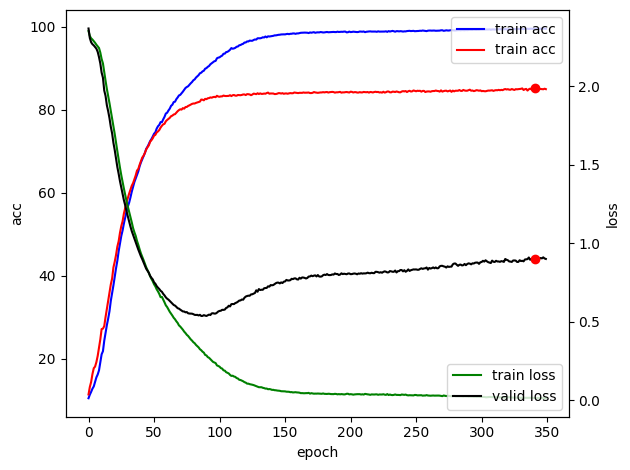

In [12]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-', label='train acc')
ax1.plot(valid_acc, 'r-', label='train acc')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()

ax2.plot(train_loss, 'g-', label='train loss')
ax2.plot(valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
ax2.legend(loc='lower right')
ax1.legend(loc='upper right')
plt.show()